In [2]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np



In [3]:
envi = ht.HyTools()
envi.read_file("export/resampled_for_landsat",'envi')

In [4]:
envi.get_pixels(500,500)

memmap([230.50578122, 264.98265027, 227.47424306, 453.65101374,
        291.14132639, 151.13075887])

In [44]:
envi.lines

6479

In [56]:
envi.columns


1119

In [40]:
envi.wavelengths

array([ 480.,  560.,  655.,  865., 1610., 2200.])

In [46]:
import numpy as np
np.arange(1, envi.lines, 1000).tolist()

[1, 1001, 2001, 3001, 4001, 5001, 6001]

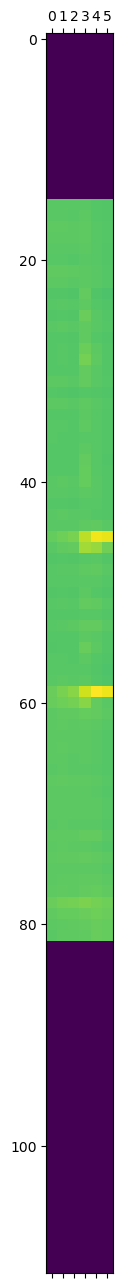

In [69]:
plt.matshow(original)

In [66]:
#plt.plot(envi.wavelengths,original[0])
rowrange = np.arange(1, 6000, 6).tolist()
colrange = np.arange(0, 1000, 1).tolist()




In [71]:
original = envi.get_pixels(rowrange, colrange)
#original = envi.get_pixels([500], [500])
#chunker = envi.get_chunk(1,envi.columns, 1,envi.lines)

for i in range(original.shape[0]): # Loop through each row/pixel
    plt.plot(envi.wavelengths, original[i, :], label=f'Pixel {i+1}')

plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Spectral Signatures')
plt.ylim(0,10000)
plt.show()

SyntaxError: unterminated string literal (detected at line 6) (461858840.py, line 6)